<a href="https://colab.research.google.com/github/Neilus03/DEEP-LEARNING-2023/blob/main/Neil_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [109]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

## Setting up

In [110]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [112]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

## Simple Autoencoder

We will define a simple MLP Autoencoder

In [113]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()#Because I know is mnist and I want output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x            

In [114]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [115]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 0.047467
epoch : 1/10, Test loss = 0.024605


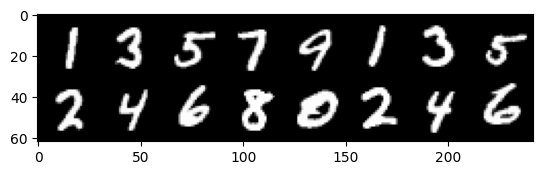

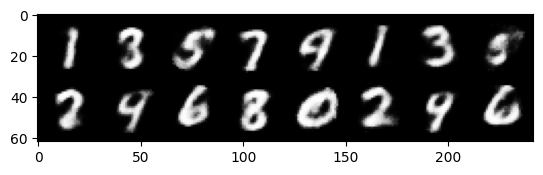

epoch : 2/10, Train loss = 0.019760
epoch : 2/10, Test loss = 0.015827


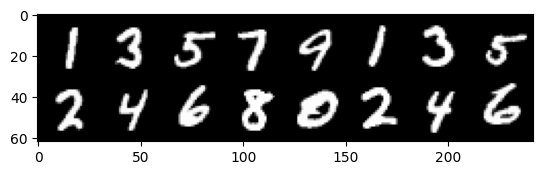

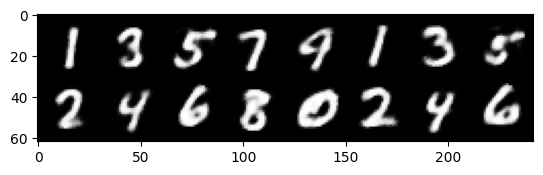

epoch : 3/10, Train loss = 0.014555
epoch : 3/10, Test loss = 0.012662


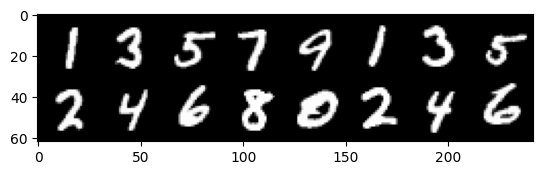

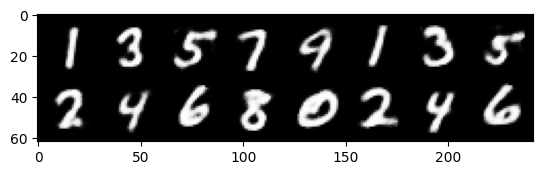

epoch : 4/10, Train loss = 0.011858
epoch : 4/10, Test loss = 0.010443


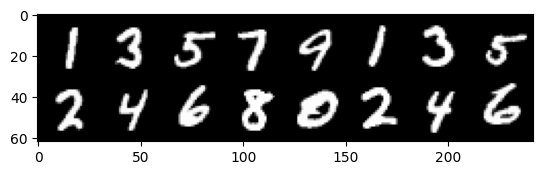

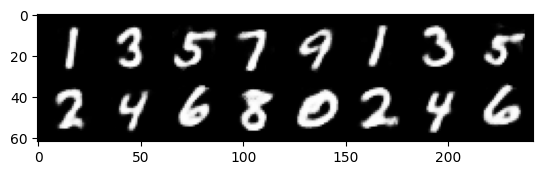

epoch : 5/10, Train loss = 0.010144
epoch : 5/10, Test loss = 0.009325


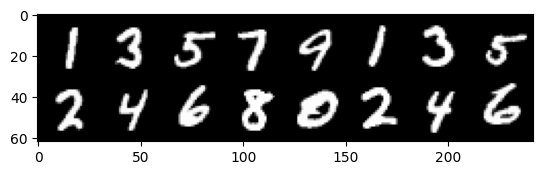

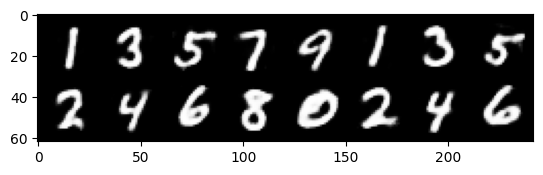

epoch : 6/10, Train loss = 0.009139
epoch : 6/10, Test loss = 0.008378


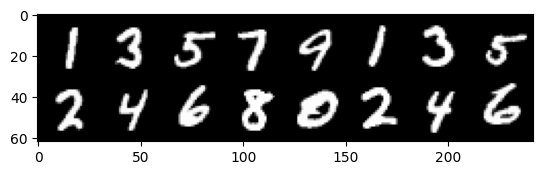

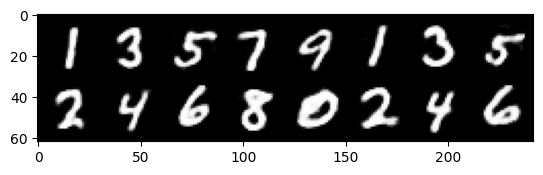

epoch : 7/10, Train loss = 0.008330
epoch : 7/10, Test loss = 0.007688


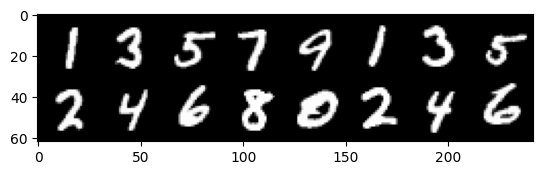

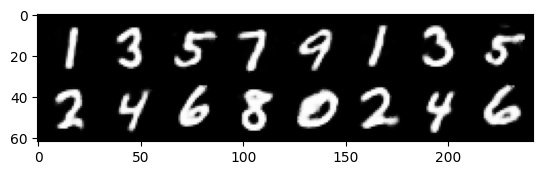

epoch : 8/10, Train loss = 0.007656
epoch : 8/10, Test loss = 0.007167


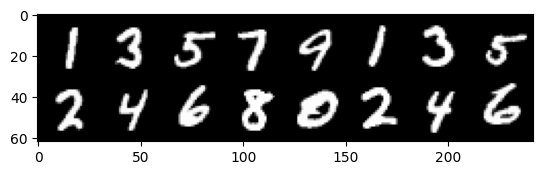

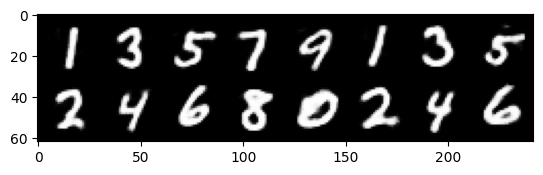

epoch : 9/10, Train loss = 0.007070
epoch : 9/10, Test loss = 0.006584


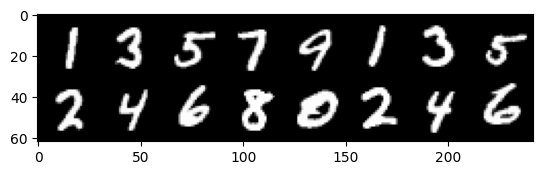

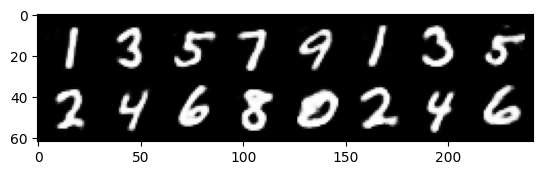

epoch : 10/10, Train loss = 0.006619
epoch : 10/10, Test loss = 0.006236


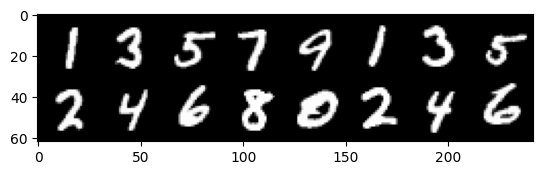

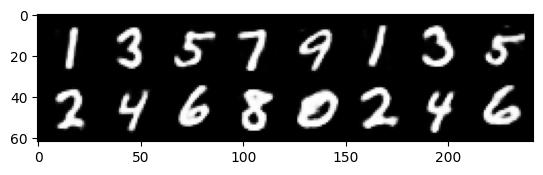

In [116]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True) 

## Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [117]:
'''
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            
            # THIS PART IS MISSING...
            
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
'''

'\nclass ConvAE(nn.Module):\n    def __init__(self):\n        super(ConvAE, self).__init__()\n        self.encoder = nn.Sequential(\n            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10\n            nn.ReLU(),\n            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5\n            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3\n            nn.ReLU(),\n            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2\n        )\n        self.decoder = nn.Sequential(\n            \n            # THIS PART IS MISSING...\n            \n            \n        )\n\n    def forward(self, x):\n        x = self.encoder(x)\n        x = self.decoder(x)\n        return x\n'

<span style="color:blue">

## **Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

In [118]:
# Your code here
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), #b, 16, 5, 5   :  n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (2-1)2-2*0+3 = 1x2-2x0+3 = 5 ---> 16 x 5 x 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), #b, 8, 15, 15   :   n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (5-1)3-2*1+5 = 4x3-2+5 = 15 ---> 8 x 15 x 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), #b, 1, 28, 28    :   n[l]=(n[l−1]−1)s−2p+f ----> n[l] = (15-1)2-2*1+2 = 14x2-2+2 = 28 ---> 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


epoch : 1/10, Train loss = 0.114538
epoch : 1/10, Test loss = 0.096922


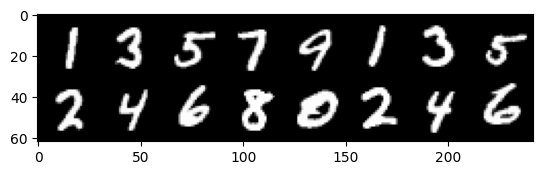

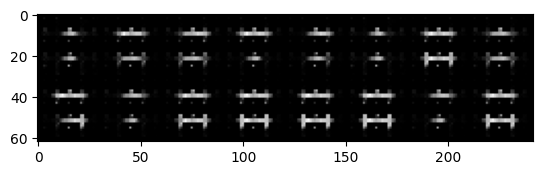

epoch : 2/10, Train loss = 0.054095
epoch : 2/10, Test loss = 0.042637


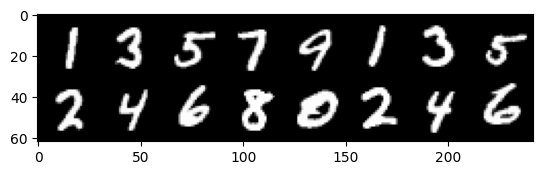

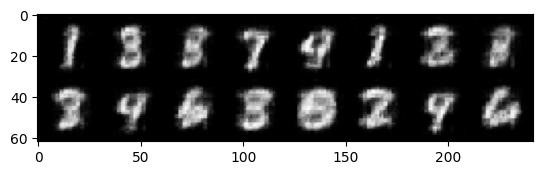

epoch : 3/10, Train loss = 0.039898
epoch : 3/10, Test loss = 0.037536


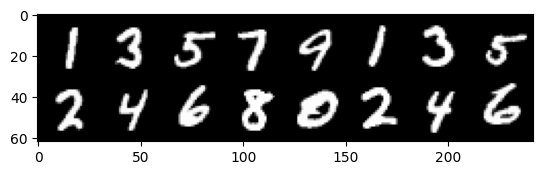

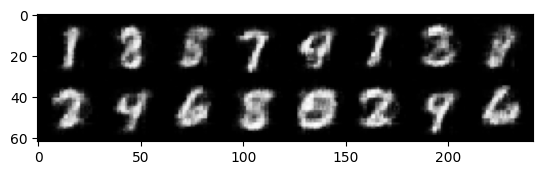

epoch : 4/10, Train loss = 0.036749
epoch : 4/10, Test loss = 0.035518


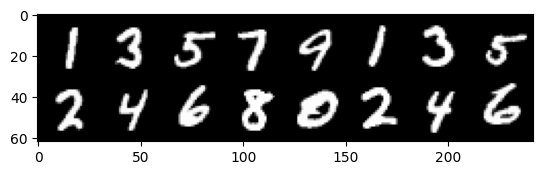

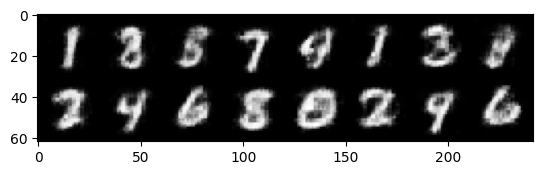

epoch : 5/10, Train loss = 0.035141
epoch : 5/10, Test loss = 0.033867


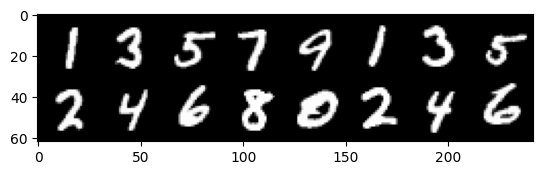

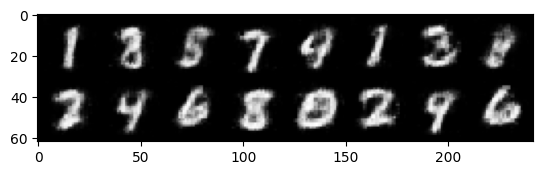

epoch : 6/10, Train loss = 0.033744
epoch : 6/10, Test loss = 0.032493


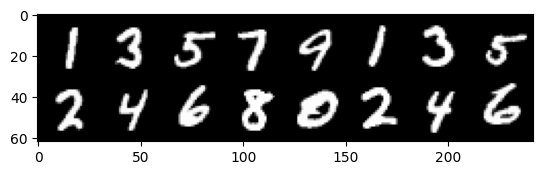

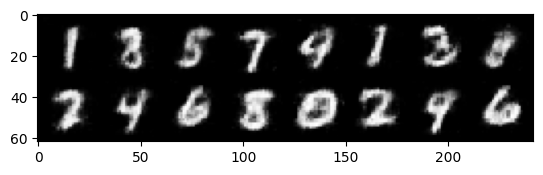

epoch : 7/10, Train loss = 0.032547
epoch : 7/10, Test loss = 0.031589


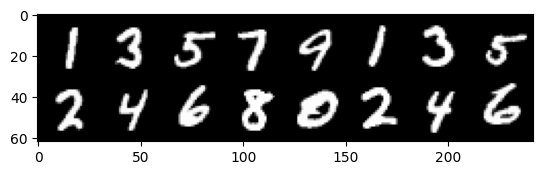

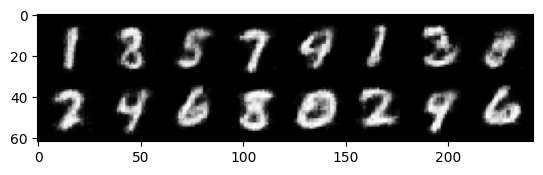

epoch : 8/10, Train loss = 0.031777
epoch : 8/10, Test loss = 0.030849


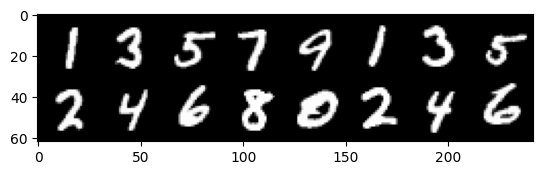

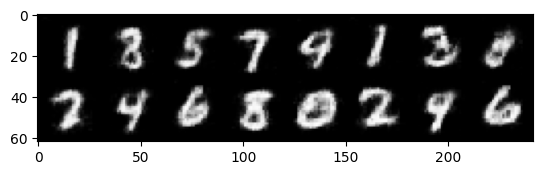

epoch : 9/10, Train loss = 0.031195
epoch : 9/10, Test loss = 0.030655


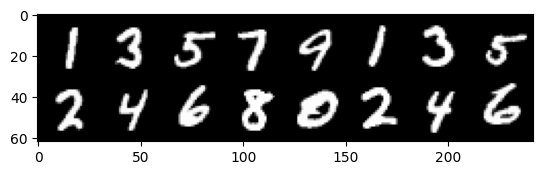

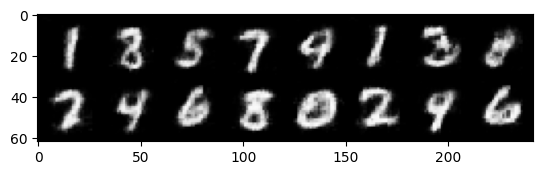

epoch : 10/10, Train loss = 0.030680
epoch : 10/10, Test loss = 0.029728


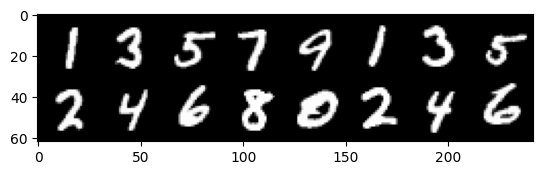

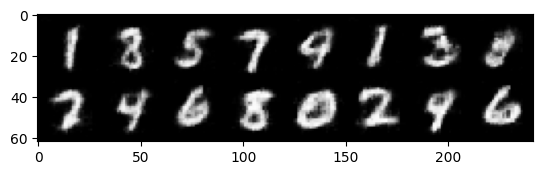

In [119]:
ConvAE = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader, criterion, reshape=False) 

<span style="color:blue">

##**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [120]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.pooling import MaxUnpool2d
# Your Code Here
class ConvAE_symmetric(nn.Module):
    def __init__(self):
        super(ConvAE_symmetric, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # b, 16, 5, 5
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1, return_indices=True)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=16,kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        indices_list = []

        for layer in self.encoder:                #------>---->---->--->
            if isinstance(layer, nn.MaxPool2d):   #------>---->---->--->
                x, indices = layer(x)             #------>---->---->--->
                indices_list.append(indices)      #------>---->---->--->
            else:                                 #------>---->---->--->
                x = layer(x)                      #------>---->---->--->
        
        idx = 1

        for layer in self.decoder:                     
            if isinstance(layer, nn.MaxUnpool2d):       #<----<-----<----
                x = layer(x, indices_list[-idx])  #<----<-----<----
                idx += 1                          #<----<-----<----
            else:                                       #<----<-----<----
                x = layer(x)                            #<----<-----<----
        return x

epoch : 1/10, Train loss = 0.075845
epoch : 1/10, Test loss = 0.041288


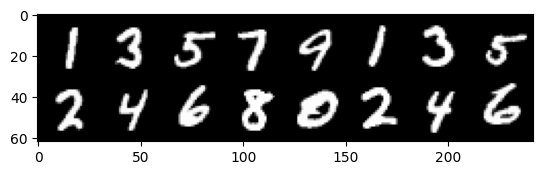

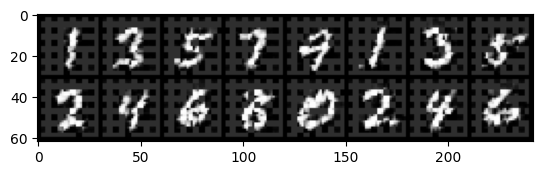

epoch : 2/10, Train loss = 0.032829
epoch : 2/10, Test loss = 0.027515


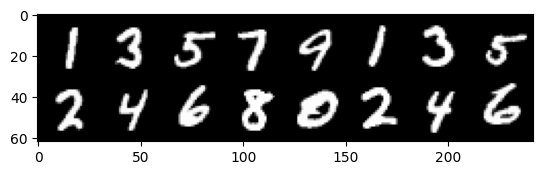

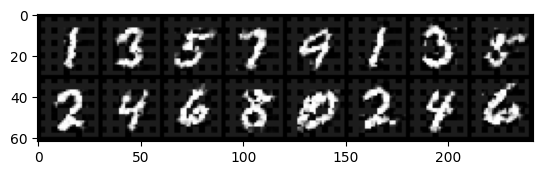

epoch : 3/10, Train loss = 0.024343
epoch : 3/10, Test loss = 0.022711


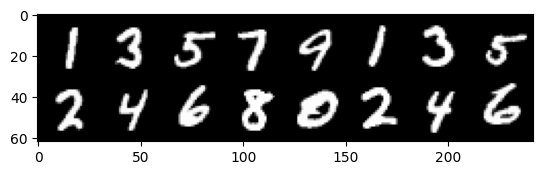

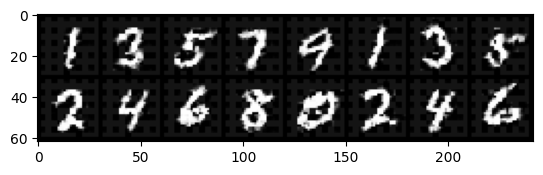

epoch : 4/10, Train loss = 0.021030
epoch : 4/10, Test loss = 0.020082


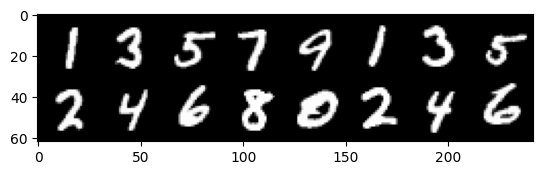

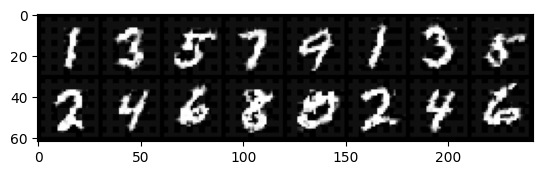

epoch : 5/10, Train loss = 0.019674
epoch : 5/10, Test loss = 0.019488


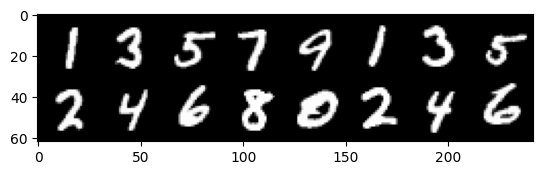

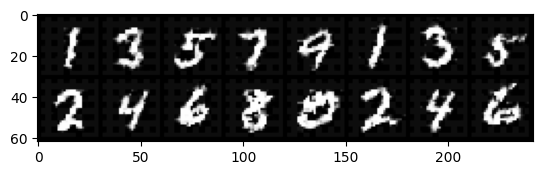

epoch : 6/10, Train loss = 0.019141
epoch : 6/10, Test loss = 0.018832


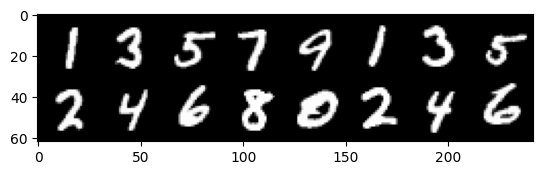

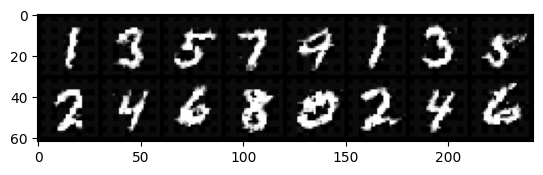

epoch : 7/10, Train loss = 0.018786
epoch : 7/10, Test loss = 0.018633


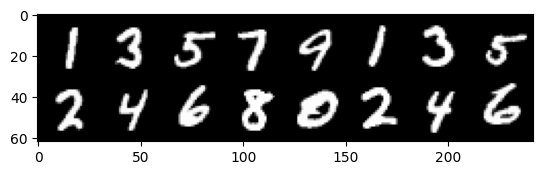

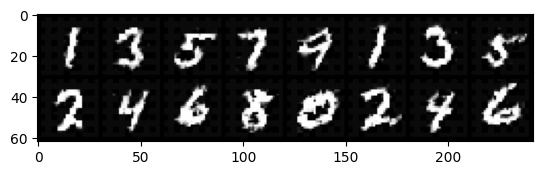

epoch : 8/10, Train loss = 0.018672
epoch : 8/10, Test loss = 0.018753


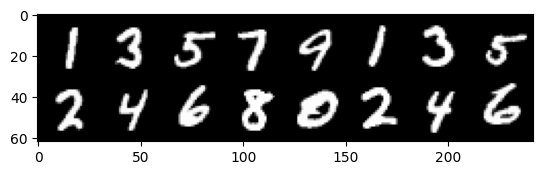

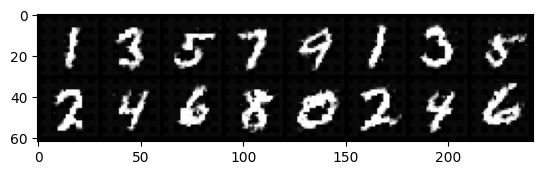

epoch : 9/10, Train loss = 0.018649
epoch : 9/10, Test loss = 0.018516


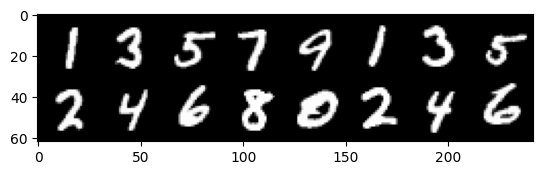

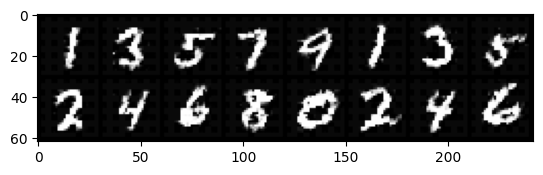

epoch : 10/10, Train loss = 0.018487
epoch : 10/10, Test loss = 0.018469


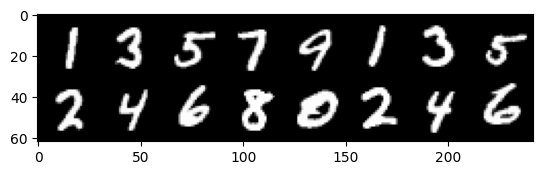

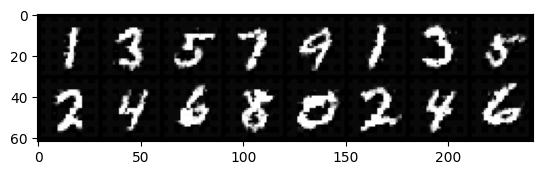

In [121]:
ConvAE_symmetric = ConvAE_symmetric().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE_symmetric.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(ConvAE_symmetric, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE_symmetric, test_loader, criterion, reshape=False) 

## Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [122]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [123]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [124]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-3)

criterion = loss_function #loss_function = recLoss(recon_x, x) + KLD

In [125]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()    
    
    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()
    
    for batch_features, _ in loader:
        batch_features = batch_features.to(device)
        
        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)
        
        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)
 
        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()
    
    # compute the epoch test loss
    loss = loss / len(loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))   

epoch : 1/10, Train loss = 5796.216032
epoch : 1/10, Test loss = 1159.560223


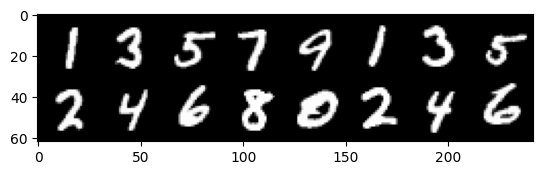

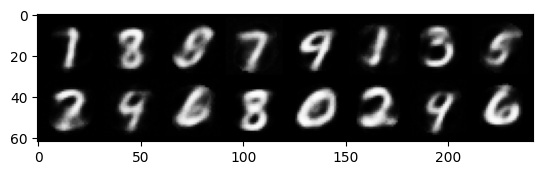

epoch : 2/10, Train loss = 4467.607848
epoch : 2/10, Test loss = 1067.619215


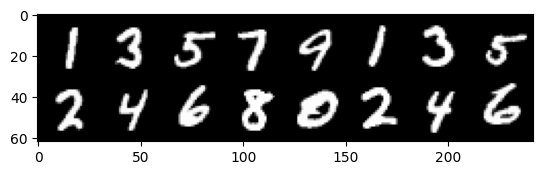

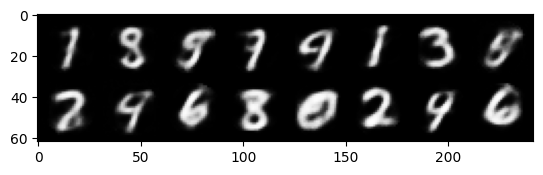

epoch : 3/10, Train loss = 4230.555761
epoch : 3/10, Test loss = 1029.537539


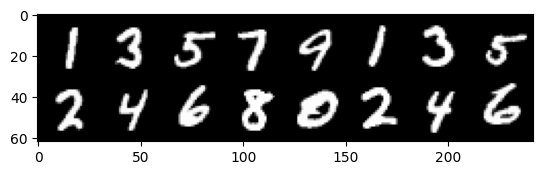

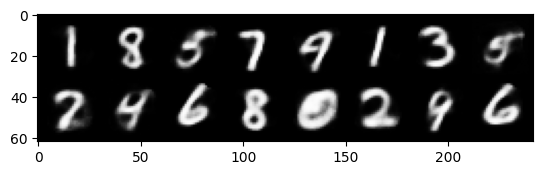

epoch : 4/10, Train loss = 4121.490814
epoch : 4/10, Test loss = 1011.868061


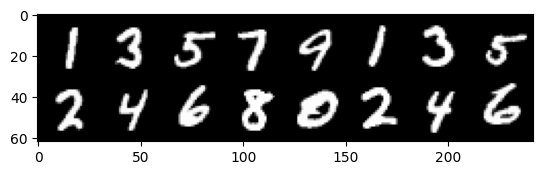

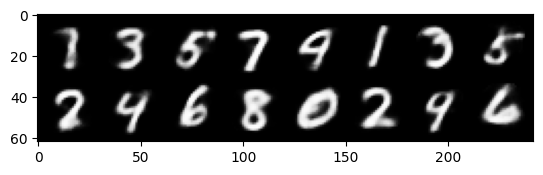

epoch : 5/10, Train loss = 4053.932564
epoch : 5/10, Test loss = 995.135366


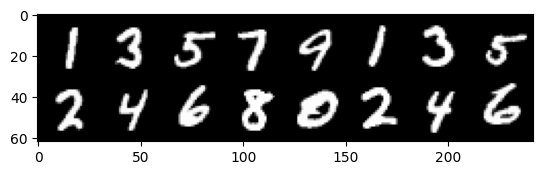

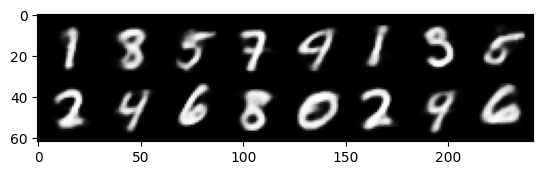

epoch : 6/10, Train loss = 4009.003371
epoch : 6/10, Test loss = 988.238110


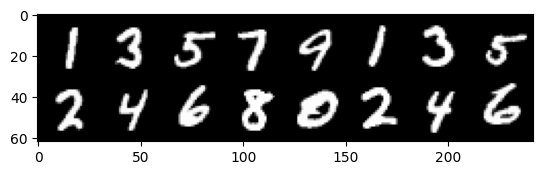

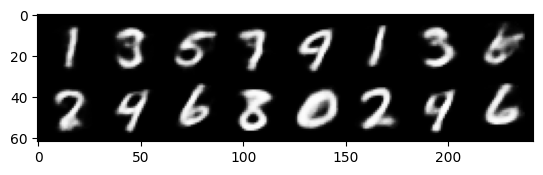

epoch : 7/10, Train loss = 3978.092533
epoch : 7/10, Test loss = 980.995574


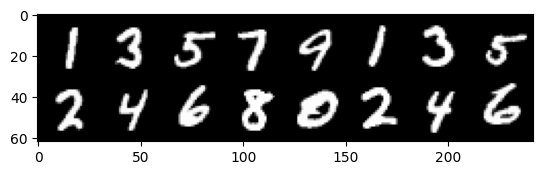

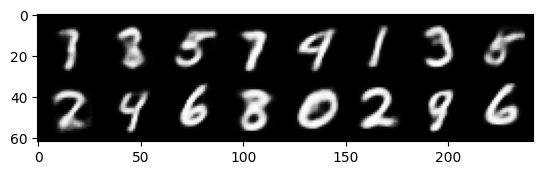

epoch : 8/10, Train loss = 3954.021790
epoch : 8/10, Test loss = 977.993827


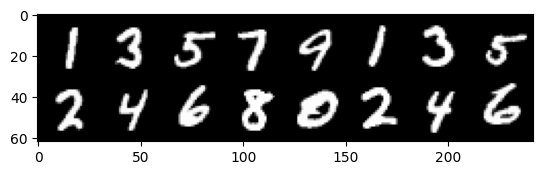

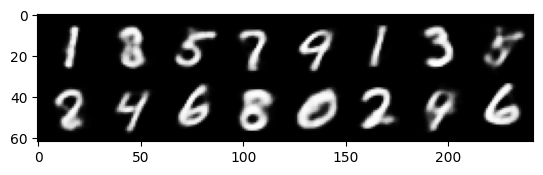

epoch : 9/10, Train loss = 3930.307108
epoch : 9/10, Test loss = 972.496634


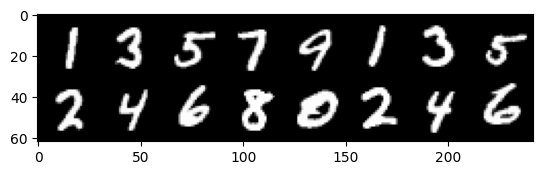

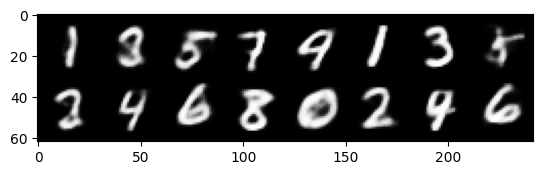

epoch : 10/10, Train loss = 3917.678972
epoch : 10/10, Test loss = 969.275336


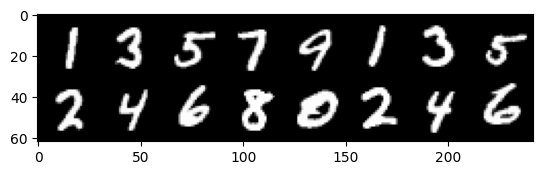

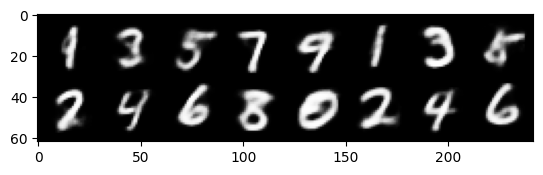

In [126]:
epochs=10
for epoch in range(epochs):
    train_vae(VAE, train_loader, optimizer, criterion)
    test_vae(VAE, test_loader, criterion) 

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [127]:
model.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):   
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits
    
    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])
    
        inter_image = inter_image.view(1, 28, 28)
        
        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show() 

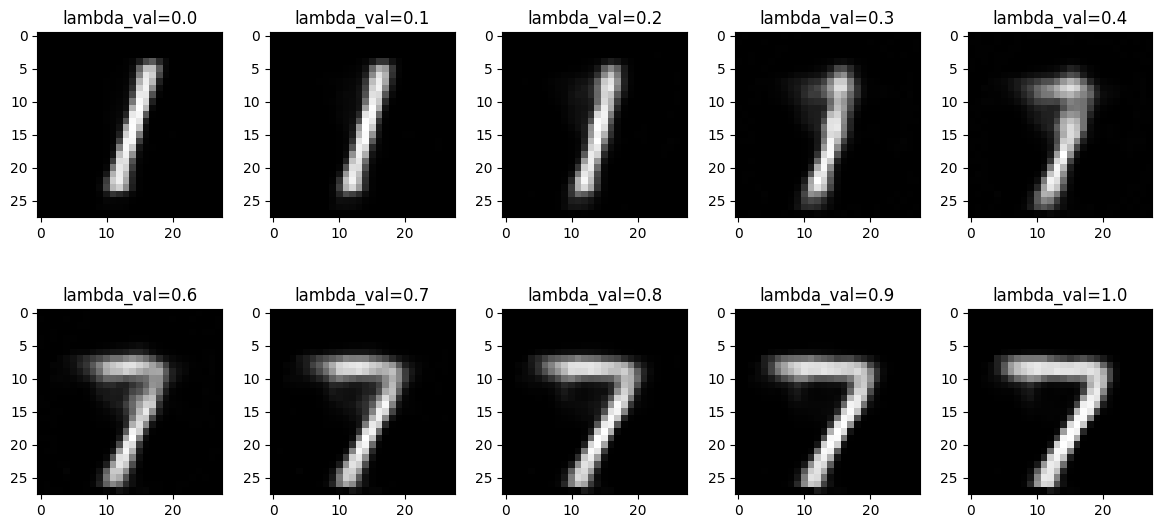

In [128]:
visualize_interpolation(VAE, test_loader, 1, 7)

<span style="color:blue">

## **Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

In [129]:
# Your Code Here

#I first will sample 100 random latent vectors, and as my VAE's bottleneck is of 20 dimensions, that will be my latent dim: 

num_samples = 100
latent_dim = 20
random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)


with torch.no_grad():
    #now I should decode the random latent vectors :
    generated_images = VAE.decode(random_latent_vectors)

#and reshape the generated images:
generated_images = generated_images.view(num_samples, 28, 28).cpu().numpy()


Let's visualize the generated digits!

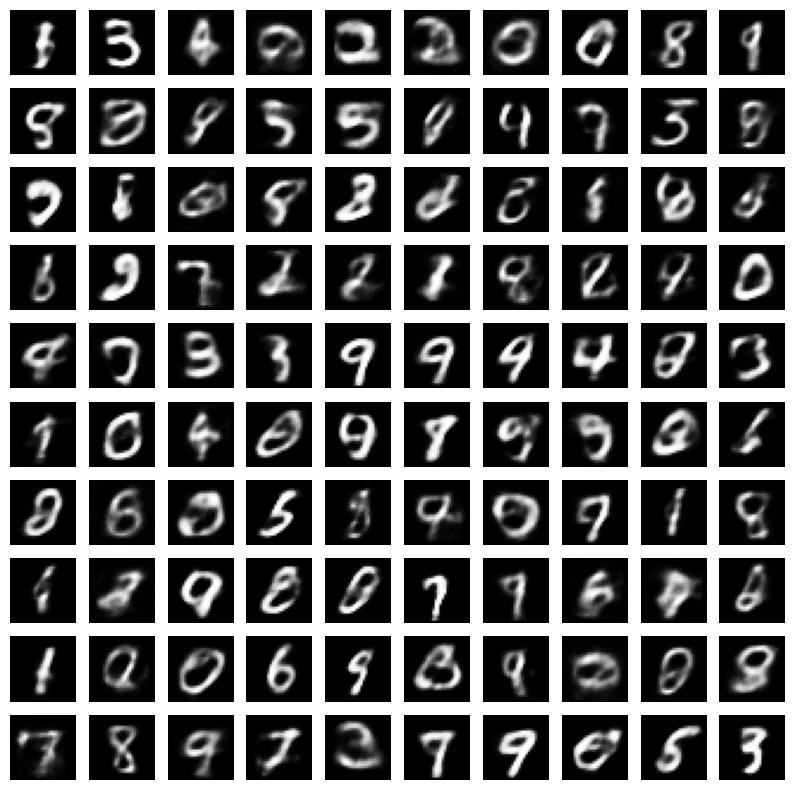

In [130]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap= "gray") # if cmap not set to gray green and blue colors are displayed, looks amazing but I want to keep the same esthetic through all the code 
    ax.axis("off") #If I don't set ax.axis to off every subplot will have the axis so I took them off

plt.show()


<span style="color:blue">

##**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

In [131]:
class VAE2D(nn.Module):
    def __init__(self):
        super(VAE2D, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space
        self.fc22 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [132]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE2D = VAE2D().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(VAE2D.parameters(), lr=1e-3)

criterion = loss_function #loss_function = recLoss(recon_x, x) + KLD

epoch : 1/10, Train loss = 6243.584121
epoch : 1/10, Test loss = 1389.733766


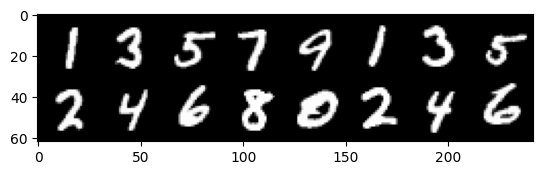

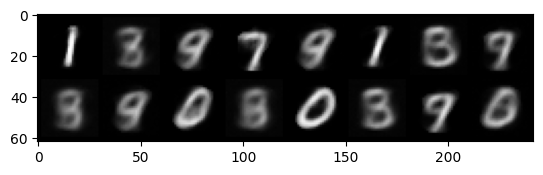

epoch : 2/10, Train loss = 5453.812126
epoch : 2/10, Test loss = 1341.188420


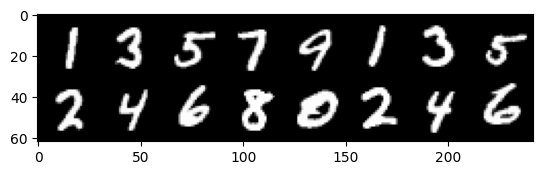

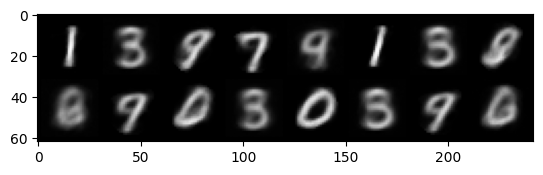

epoch : 3/10, Train loss = 5326.106341
epoch : 3/10, Test loss = 1319.474331


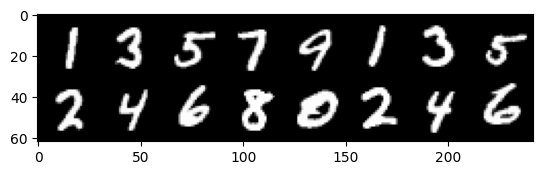

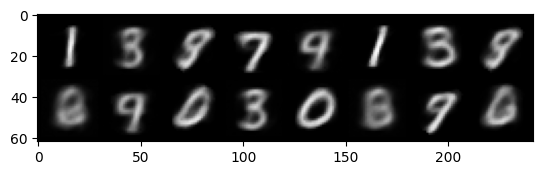

epoch : 4/10, Train loss = 5253.344581
epoch : 4/10, Test loss = 1303.405333


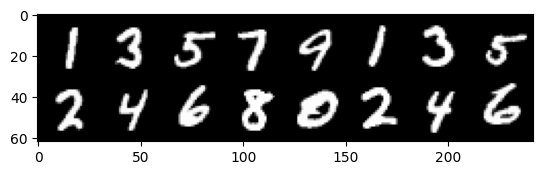

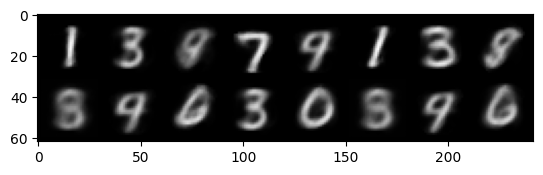

epoch : 5/10, Train loss = 5193.471251
epoch : 5/10, Test loss = 1290.272208


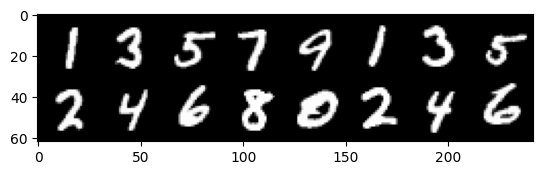

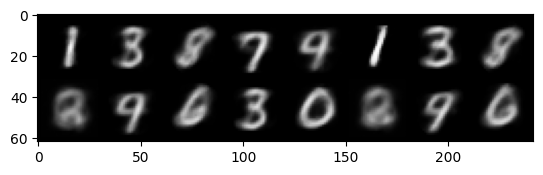

epoch : 6/10, Train loss = 5142.354383
epoch : 6/10, Test loss = 1281.210115


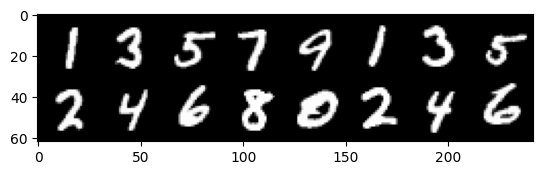

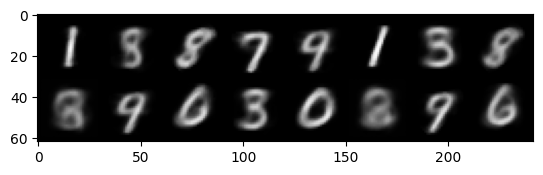

epoch : 7/10, Train loss = 5103.198223
epoch : 7/10, Test loss = 1278.290663


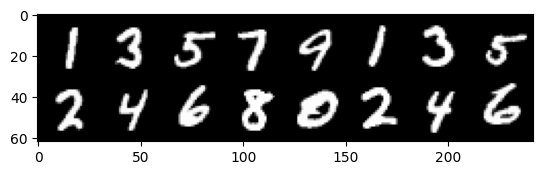

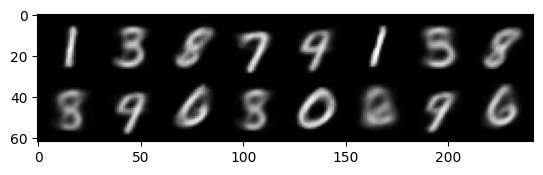

epoch : 8/10, Train loss = 5066.427546
epoch : 8/10, Test loss = 1265.368549


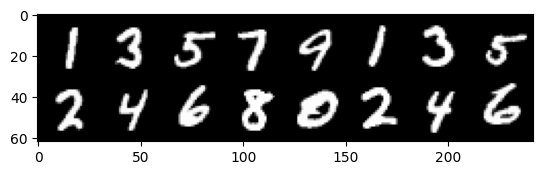

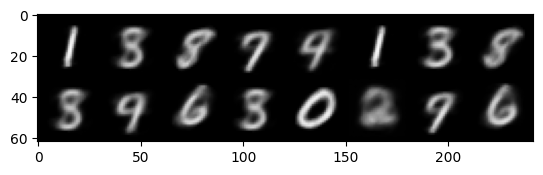

epoch : 9/10, Train loss = 5035.861528
epoch : 9/10, Test loss = 1260.556869


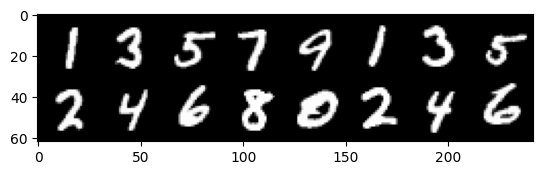

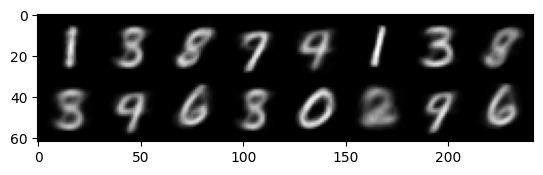

epoch : 10/10, Train loss = 5013.224236
epoch : 10/10, Test loss = 1251.736308


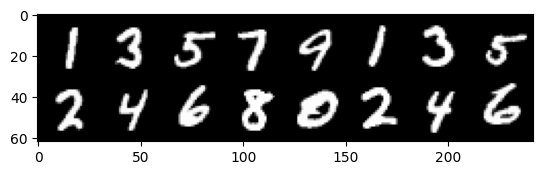

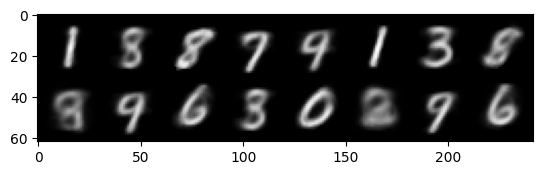

In [133]:
epochs=10
for epoch in range(epochs):
    train_vae(VAE2D, train_loader, optimizer, criterion)
    test_vae(VAE2D, test_loader, criterion) 

Is totally normal that the quality of the digits generated decrease bc of the huge amount of information lost. 

The 2D latent space is mainly used for visualization purposes and to understand how the VAE learns to represent the data in a lower-dimensional space. 

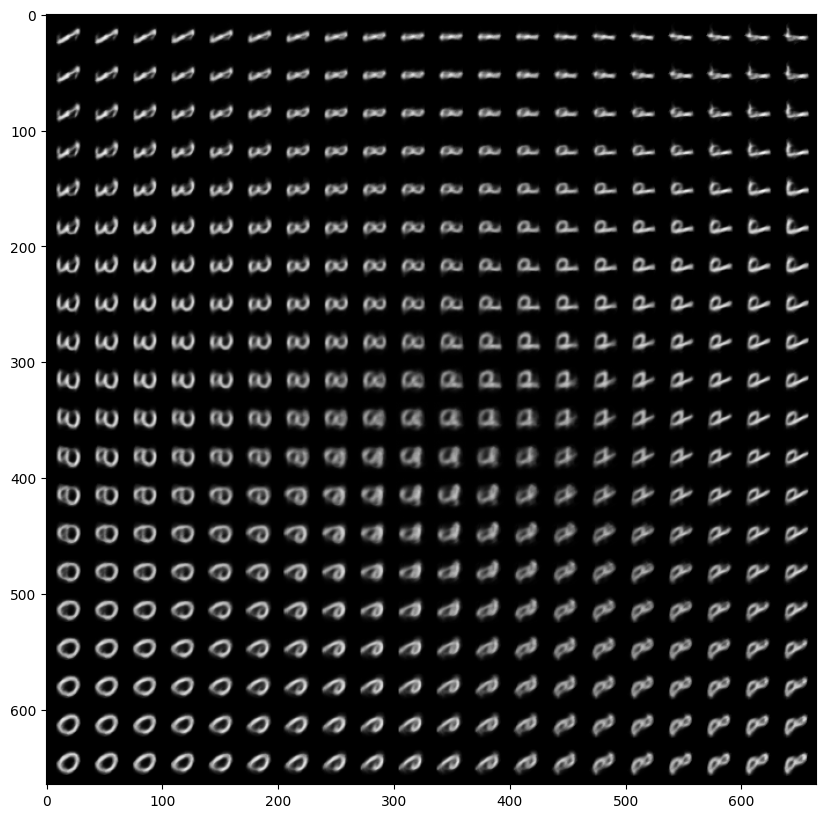

In [134]:
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    # Your code here
    image_recon = VAE2D.decode(latents.to(device)).cpu()
   
    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28),20,5))
    plt.show()

 <span style="color:blue">

## **Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [173]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

Simple Autoencoder:

In [136]:
AE = AE(input_size=784).to(device)
# create an optimizer object
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.037311
epoch : 1/10, Test loss = 0.021906


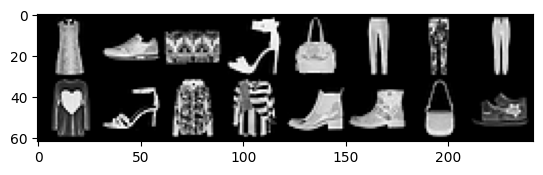

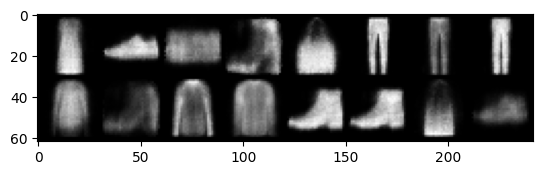

epoch : 2/10, Train loss = 0.019568
epoch : 2/10, Test loss = 0.017922


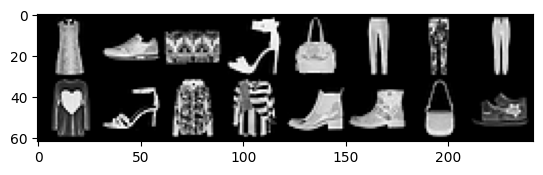

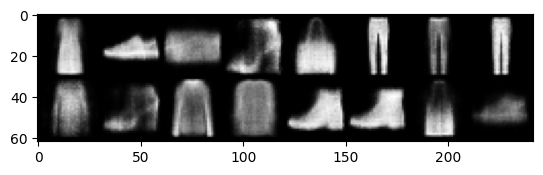

epoch : 3/10, Train loss = 0.016783
epoch : 3/10, Test loss = 0.015738


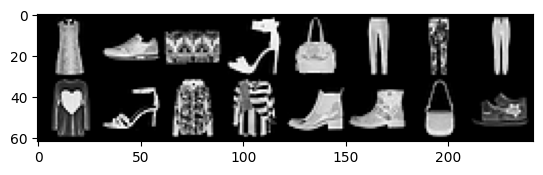

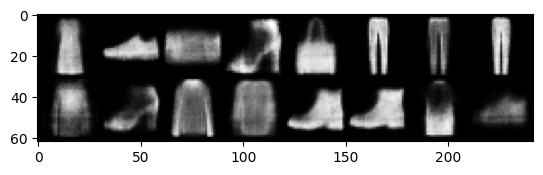

epoch : 4/10, Train loss = 0.014908
epoch : 4/10, Test loss = 0.014249


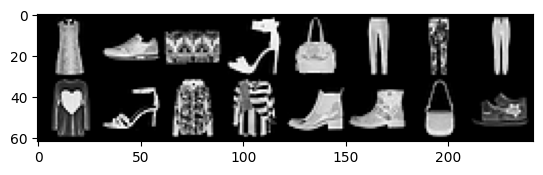

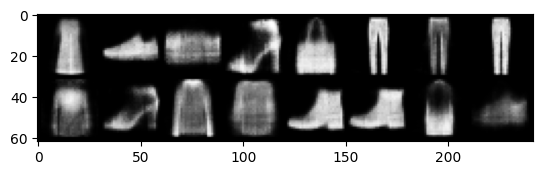

epoch : 5/10, Train loss = 0.013775
epoch : 5/10, Test loss = 0.013370


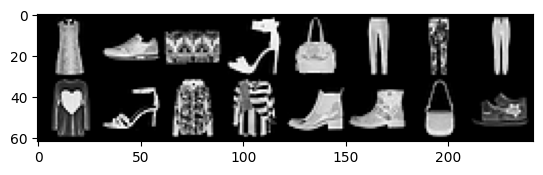

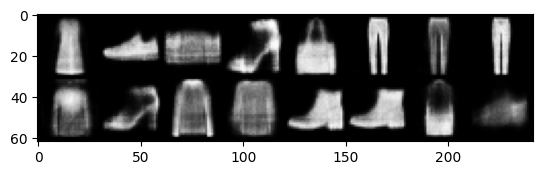

epoch : 6/10, Train loss = 0.012921
epoch : 6/10, Test loss = 0.012666


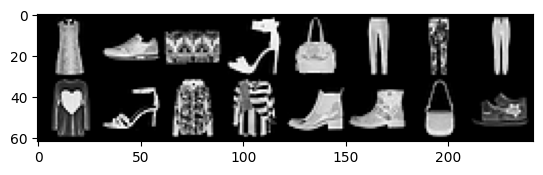

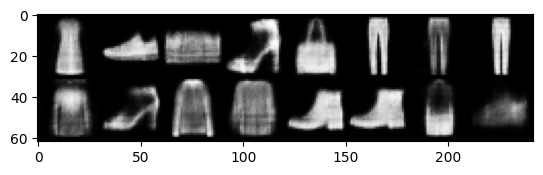

epoch : 7/10, Train loss = 0.012234
epoch : 7/10, Test loss = 0.012044


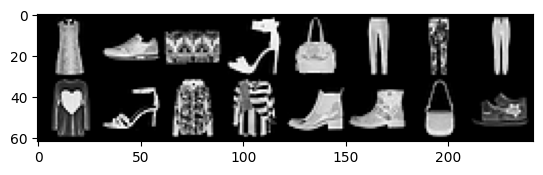

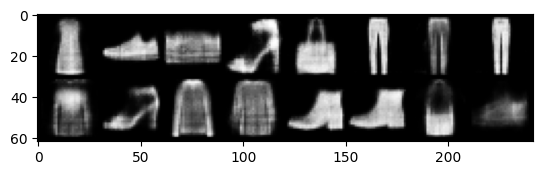

epoch : 8/10, Train loss = 0.011715
epoch : 8/10, Test loss = 0.011587


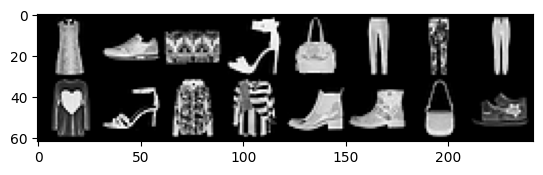

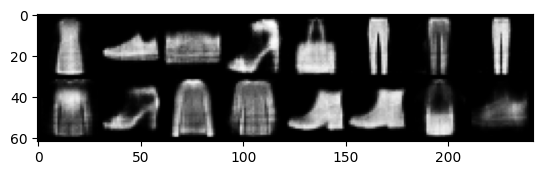

epoch : 9/10, Train loss = 0.011273
epoch : 9/10, Test loss = 0.011163


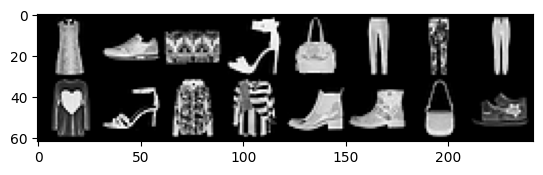

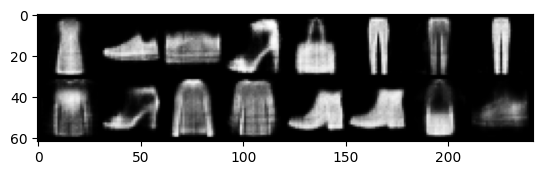

epoch : 10/10, Train loss = 0.010885
epoch : 10/10, Test loss = 0.010842


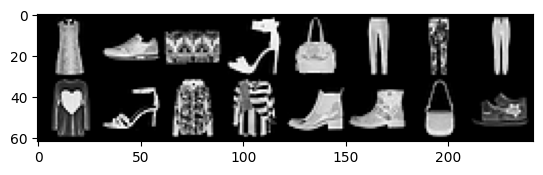

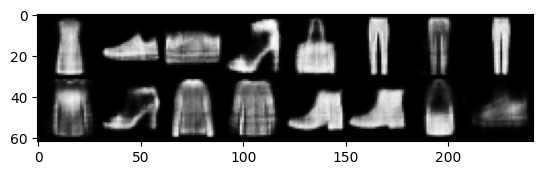

In [137]:
epochs=10
for epoch in range(epochs):
    train(AE, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(AE, test_loader_FMNIST, criterion, reshape=True) 

Convolutional Autoencoder:

In [138]:
# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epoch : 1/10, Train loss = 0.035537
epoch : 1/10, Test loss = 0.029933


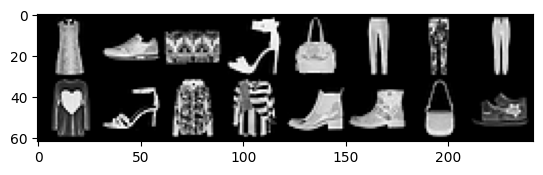

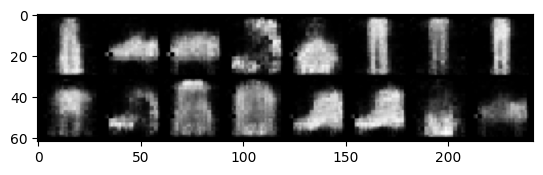

epoch : 2/10, Train loss = 0.028434
epoch : 2/10, Test loss = 0.027180


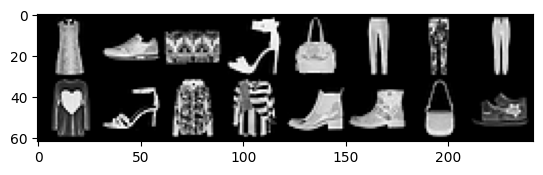

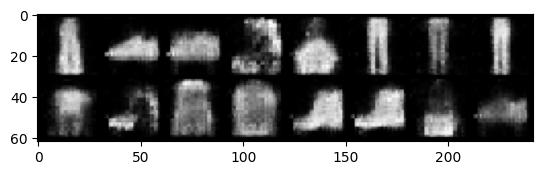

epoch : 3/10, Train loss = 0.026600
epoch : 3/10, Test loss = 0.026019


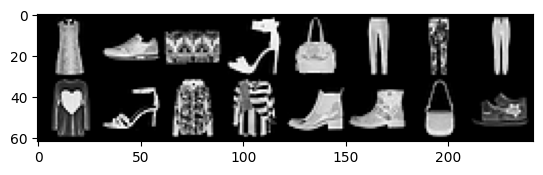

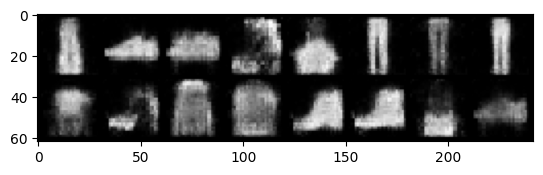

epoch : 4/10, Train loss = 0.025597
epoch : 4/10, Test loss = 0.025368


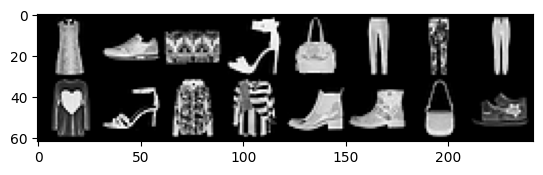

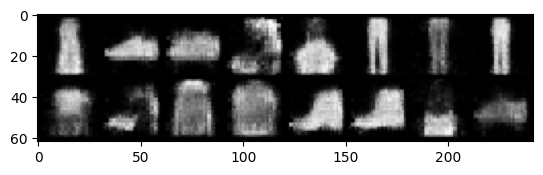

epoch : 5/10, Train loss = 0.024992
epoch : 5/10, Test loss = 0.024771


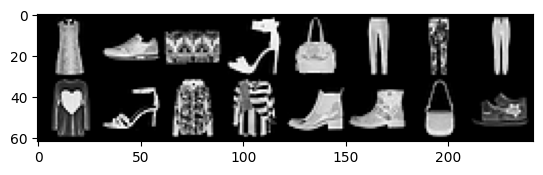

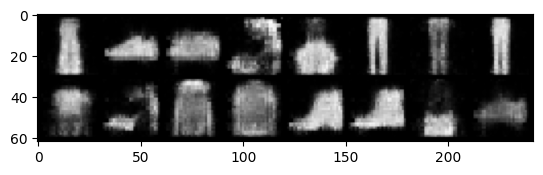

epoch : 6/10, Train loss = 0.024540
epoch : 6/10, Test loss = 0.024396


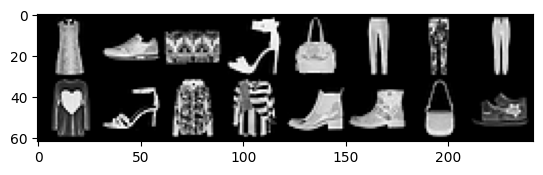

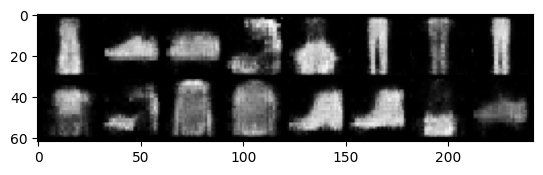

epoch : 7/10, Train loss = 0.024058
epoch : 7/10, Test loss = 0.023864


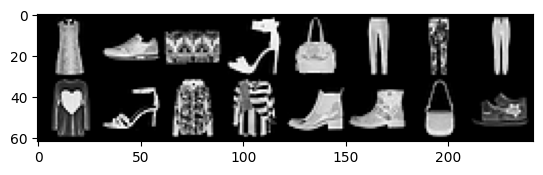

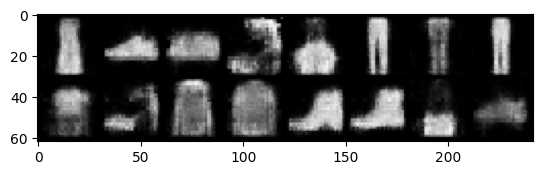

epoch : 8/10, Train loss = 0.023740
epoch : 8/10, Test loss = 0.023789


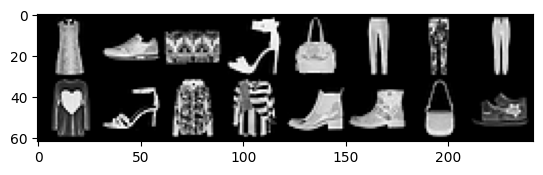

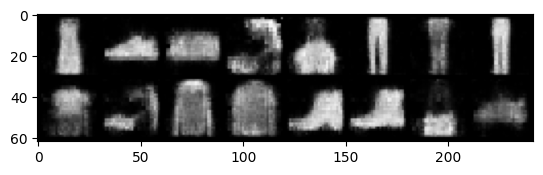

epoch : 9/10, Train loss = 0.023440
epoch : 9/10, Test loss = 0.023454


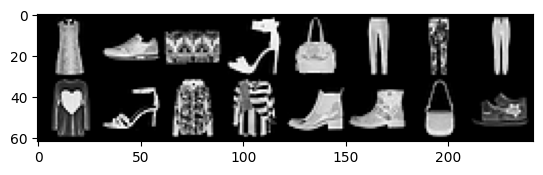

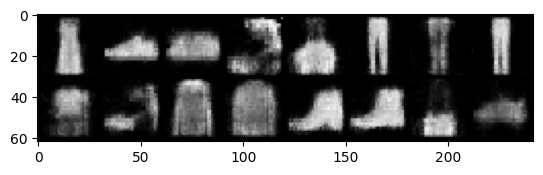

epoch : 10/10, Train loss = 0.023242
epoch : 10/10, Test loss = 0.023242


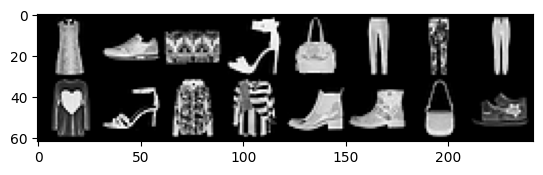

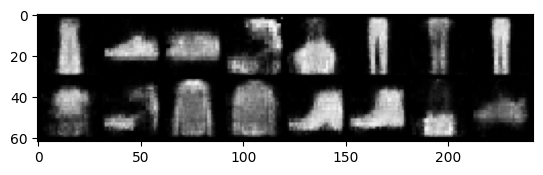

In [139]:
epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader_FMNIST, criterion, reshape=False) 

Symmetric Convolutional Autoencoder:

In [140]:
# create an optimizer object
optimizer = torch.optim.Adam(ConvAE_symmetric.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epoch : 1/10, Train loss = 0.060452
epoch : 1/10, Test loss = 0.053278


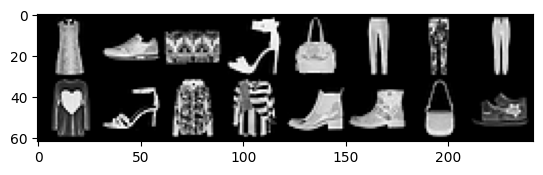

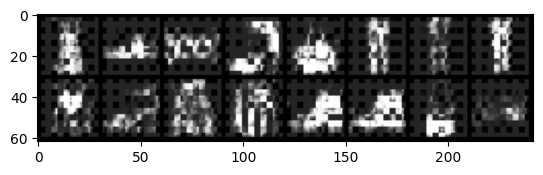

epoch : 2/10, Train loss = 0.052154
epoch : 2/10, Test loss = 0.051302


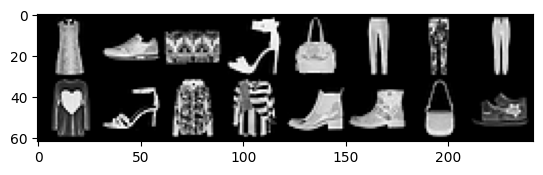

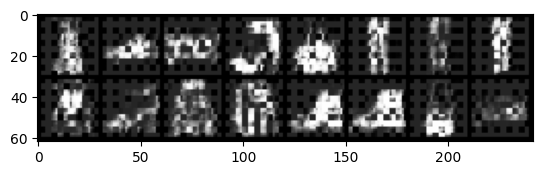

epoch : 3/10, Train loss = 0.052308
epoch : 3/10, Test loss = 0.051961


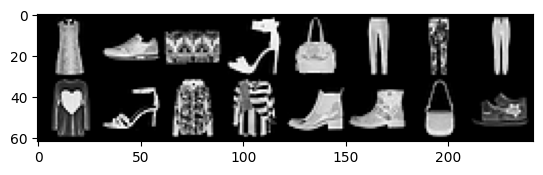

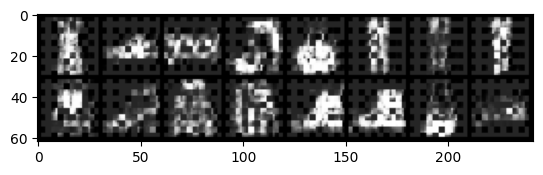

epoch : 4/10, Train loss = 0.051537
epoch : 4/10, Test loss = 0.051100


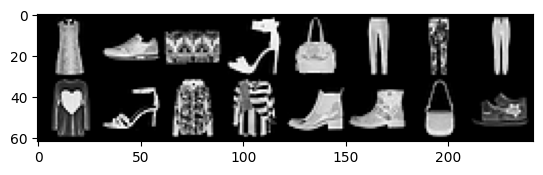

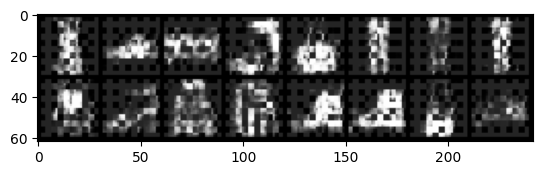

epoch : 5/10, Train loss = 0.050944
epoch : 5/10, Test loss = 0.050816


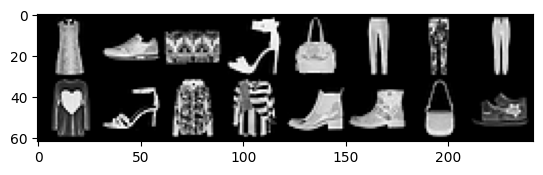

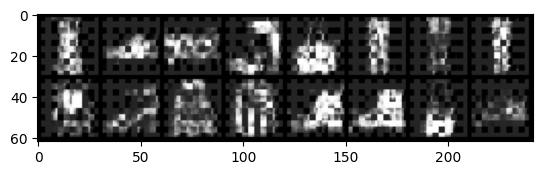

epoch : 6/10, Train loss = 0.050571
epoch : 6/10, Test loss = 0.050678


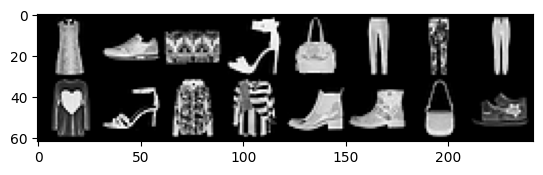

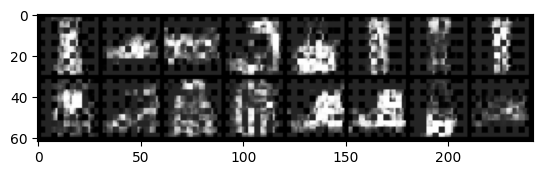

epoch : 7/10, Train loss = 0.050147
epoch : 7/10, Test loss = 0.050359


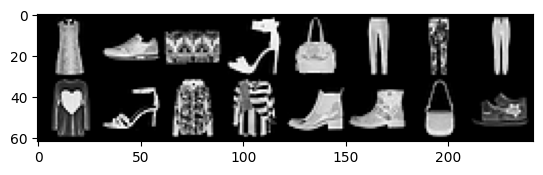

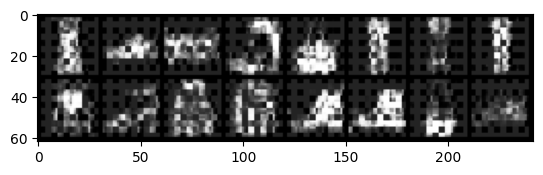

epoch : 8/10, Train loss = 0.049517
epoch : 8/10, Test loss = 0.049166


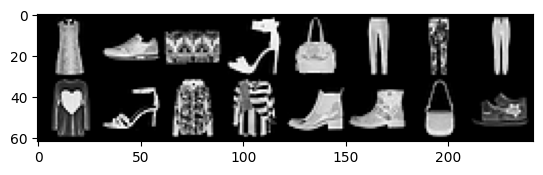

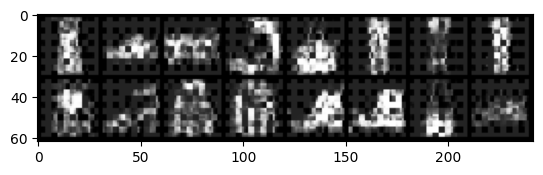

epoch : 9/10, Train loss = 0.048985
epoch : 9/10, Test loss = 0.049009


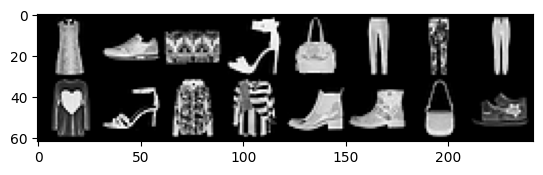

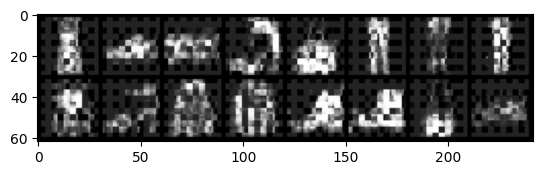

epoch : 10/10, Train loss = 0.048683
epoch : 10/10, Test loss = 0.048471


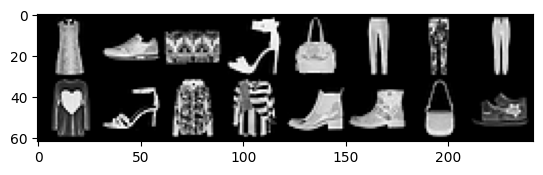

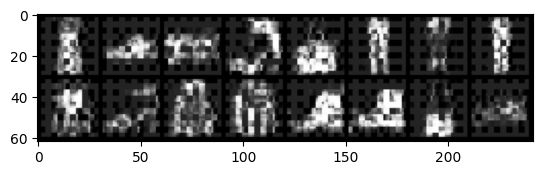

In [141]:
epochs=10
for epoch in range(epochs):
    train(ConvAE_symmetric, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(ConvAE_symmetric, test_loader_FMNIST, criterion, reshape=False) 